In [29]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import time
from random import choice
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from moviepy.editor import VideoFileClip
%matplotlib inline

# 1. Explore the Data

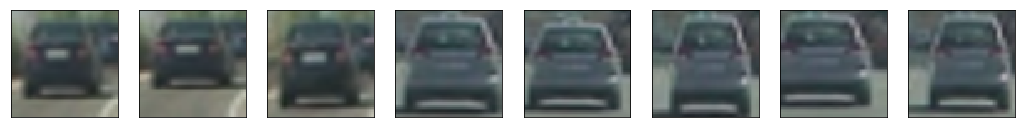

Total vehicle: 8792
Image size: (64, 64, 3)


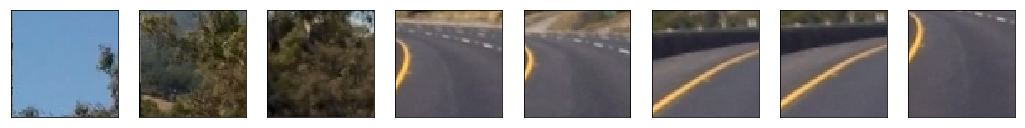

Total non-vehicle: 9666
Image size: (64, 64, 3)


In [4]:
# Grab all the training images
vehicles = glob.glob('training_data/vehicles/*/*.png')
non_vehicles = glob.glob('training_data/non-vehicles/*/*.png')

# Plot some sample vehicle images
img_cnt = 8
f, ax = plt.subplots(1, img_cnt, figsize = (18, 16))
for i in range(0, img_cnt):
    sample = mpimg.imread(vehicles[i])
    ax[i].imshow(sample)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
print('Total vehicle: %d' %len(vehicles))
img_size = sample.shape
print('Image size: {}'.format(img_size))

# Plot some sample non-vehicle images
f, ax = plt.subplots(1, img_cnt, figsize = (18, 16))
for i in range(0, img_cnt):
    sample = mpimg.imread(non_vehicles[i])
    ax[i].imshow(sample)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
print('Total non-vehicle: %d' %len(non_vehicles))
img_size = sample.shape
print('Image size: {}'.format(img_size))

In [5]:
# Get the X training tdata
X = np.zeros( (len(vehicles) + len(non_vehicles), *img_size), dtype=np.float32)
i = 0
for img in vehicles:
    X[i,:,:,:] = mpimg.imread(img)
    i += 1
for img in non_vehicles:    
    X[i,:,:,:] = mpimg.imread(img)
    i += 1
    
print(X.shape)

(18458, 64, 64, 3)


In [6]:
# Get the y training data
y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles)))).astype(np.float32)
print(y.shape)

(18458,)


### Save the raw data as a pickle

In [7]:
raw_pickle = {}
raw_pickle['X'] = X
raw_pickle['y'] = y
with open('training_data/raw_pickle.p','wb') as output_file:
    pickle.dump(raw_pickle, output_file)

### Load the raw data pickle

In [8]:
with open('training_data/raw_pickle.p', 'rb') as input_file:
    p = pickle.load(input_file)
X, y = p['X'], p['y']

# 2. Feature Selection

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [10]:
def plot_hog_examples(img, orient = 9, pix_per_cell = 8, cell_per_block = 2):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    _, ax = plt.subplots(1, 6, figsize = (18, 6))
    ax[0].imshow(img)
    ax[0].set_title('original')
    
    _, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis = True)
    ax[1].imshow(gray_hog)
    ax[1].set_title('gray hog')
    
    _, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis = True)
    ax[2].imshow(h_hog)
    ax[2].set_title('h hog')
    
    _, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis = True)
    ax[3].imshow(l_hog)
    ax[3].set_title('l hog')
    
    _, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis = True)
    ax[4].imshow(s_hog)
    ax[4].set_title('s hog')
    
    _, v_hog = get_hog_features(hsv[:,:,2], orient, pix_per_cell, cell_per_block, vis = True)
    ax[5].imshow(v_hog)
    ax[5].set_title('v hog')
    
    plt.show()

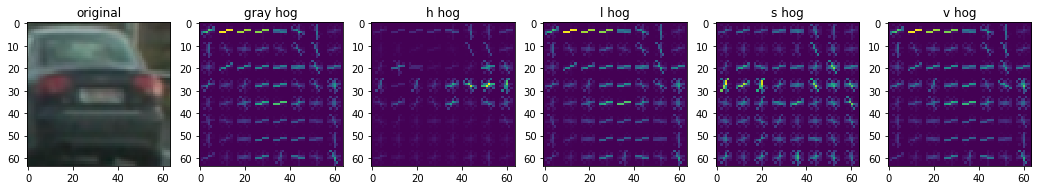

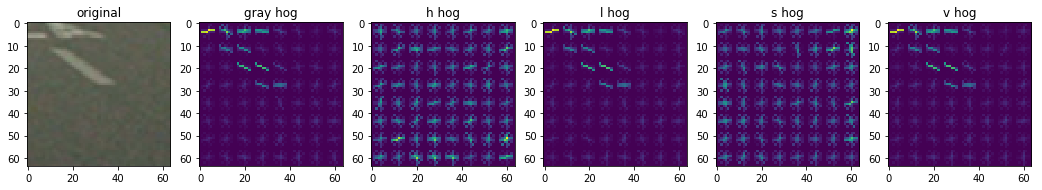

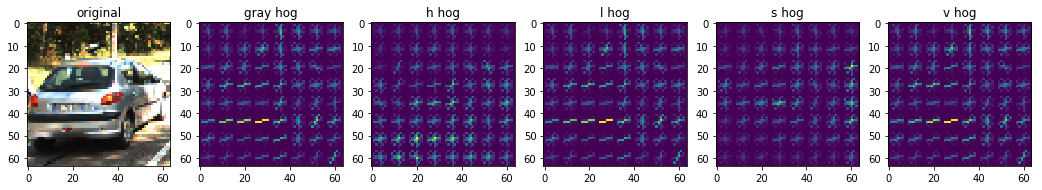

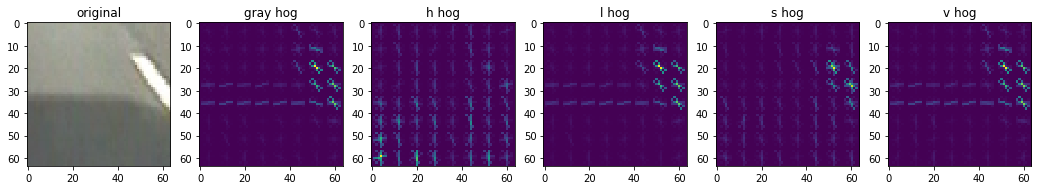

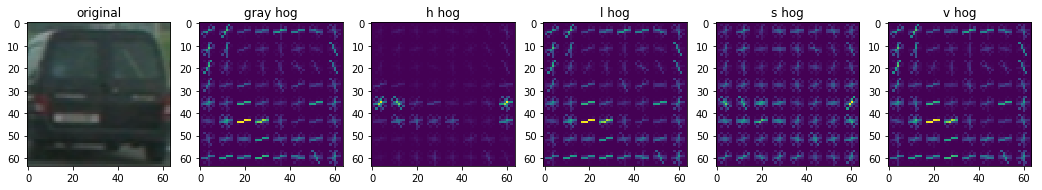

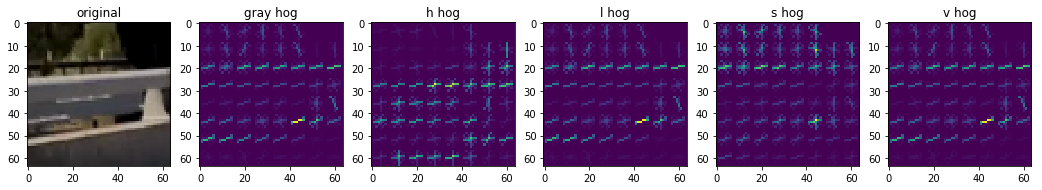

In [11]:
# Plot different HOGs from random images
for _ in range(0, 3):
    plot_hog_examples(mpimg.imread(choice(vehicles)))
    plot_hog_examples(mpimg.imread(choice(non_vehicles)))

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    cnt = imgs.shape[0]
    # Iterate through the list of images
    for i in range(0, cnt):
        # Read in each one by one
        image = imgs[i,:,:,:]
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [13]:
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t1 = time.time()
features = extract_features(X, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to extract features...' )

85.18 Seconds to extract features...


In [14]:
X = np.array(features).astype(np.float32)
X_scaler = StandardScaler().fit(features)
scaled_X = X_scaler.transform(features)
print(scaled_X.shape, y.shape)

(18458, 5292) (18458,)


# 3. Train Classifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=12345)
svc = LinearSVC()
clf = CalibratedClassifierCV(svc)
t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to train SVC...' )
print('Train Accuracy of SVC = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

50.89 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9854
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  1.  1.  1.  0.]


# 4. Sliding Window

In [16]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

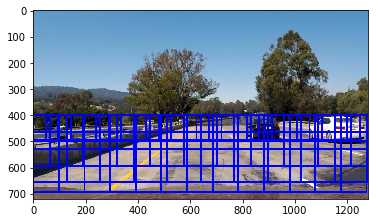

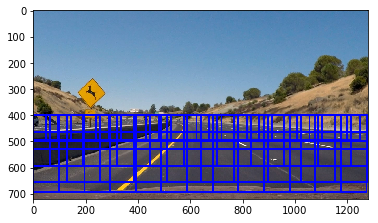

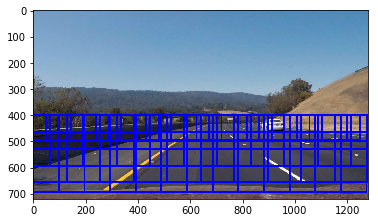

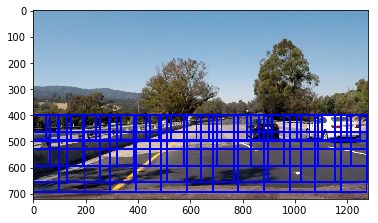

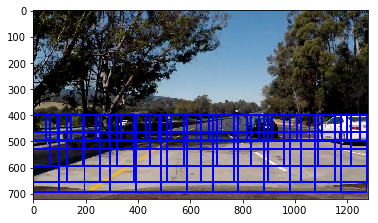

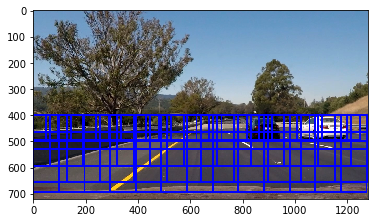

In [19]:
y_start_stops = [[400, 500],
                 [400, 600],
                 [400, 700],
                 [400, 700]]
xy_windows = [(96, 96),
              (128, 128),
              (196, 196),
              (256, 256)]
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs:
    img = mpimg.imread(img)
    windows = []
    for i in range(len(y_start_stops)):
        windows  += slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stops[i], 
                               xy_window=xy_windows[i],xy_overlap=(0.5, 0.5))
    window_img = draw_boxes(img, windows, color=(0,0,255), thick = 6)
    plt.figure()
    plt.imshow(window_img)

In [51]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def single_img_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Return the hog features
    return hog_features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict_proba(test_features)[0]
        #7) If positive (prediction == 1) then save the window
        if prediction[1] > 0.75:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

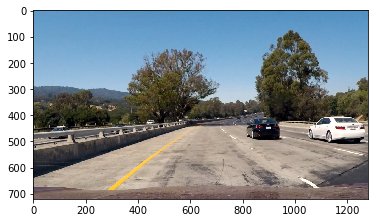

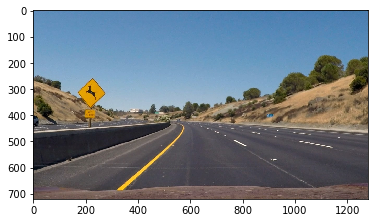

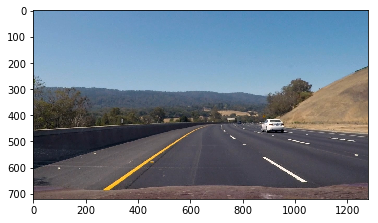

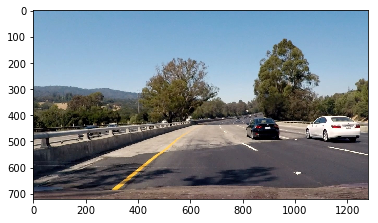

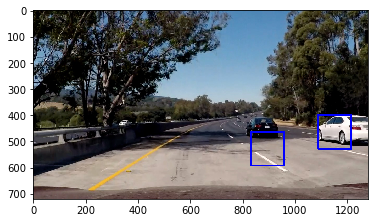

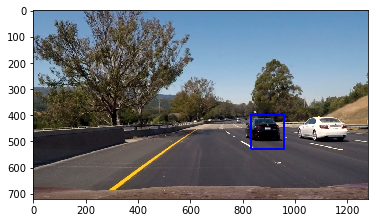

In [52]:
test_imgs = glob.glob('test_images/*.jpg')
for img in test_imgs:
    img = mpimg.imread(img)
    windows = []
    for i in range(len(y_start_stops)):
        windows  += slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stops[i], 
                               xy_window=xy_windows[i],xy_overlap=(0.5, 0.5))
    on_windows = search_windows(img, windows, clf, X_scaler, 'HLS', 9, 8, 2, 'ALL')
    window_img = draw_boxes(img, on_windows, color=(0,0,255), thick = 6)
    plt.figure()
    plt.imshow(window_img)